# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [15]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [16]:
!pip install "gymnasium[toy_text]"

In [28]:
# tạo môi trường mô phỏng
import gymnasium as gym
# numpy để làm việc với các mảng và tính toán số học
import numpy as np
# vẽ đồ thị hiển thị hình ảnh
import matplotlib.pyplot as plt

# Bài toán taxi cần đón và trả khách đúng vị trí
env = gym.make("Taxi-v3", render_mode="rgb_array")

# đặt lại môi trường về trạng thái ban đầu
print(env.reset(seed=0))
plt.imshow(env.render())


(314, {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)})


In [29]:
# Lấy số lượng trạng thái (states) có thể có trong môi trường `Taxi-v3`.
# `env.observation_space.n` trả về số lượng trạng thái trong không gian quan sát (observation space).
n_states = env.observation_space.n

# Lấy số lượng hành động (actions) có thể thực hiện trong môi trường `Taxi-v3`.
# 6 hành động bao gồm: đi lên, đi xuống, đi trái, đi phải, đón khách và trả khách.
# `env.action_space.n` trả về số lượng hành động trong không gian hành động (action space).
n_actions = env.action_space.n

# In ra số lượng trạng thái và hành động để kiểm tra.
# Ví dụ: "n_states=500, n_actions=6" (Taxi-v3 có 500 trạng thái và 6 hành động).
print(f"n_states={n_states}, n_actions={n_actions}")


n_states=500, n_actions=6


# Create stochastic policy (Tạo chính sách ngẫu nhiên)

This time our policy should be a probability distribution. 
- (Lần này, chính sách của chúng ta sẽ là một phân phối xác suất.)

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.
- (Vì chúng ta vẫn sử dụng các biểu diễn trạng thái và hành động dưới dạng số nguyên, bạn có thể sử dụng một mảng 2 chiều để biểu diễn chính sách.)

Please initialize the policy __uniformly__, that is, probabililities of all actions should be equal.
- (Hãy khởi tạo chính sách đồng đều, nghĩa là xác suất của tất cả các hành động phải bằng nhau.)

In [30]:
def initialize_policy(n_states, n_actions):
    ## Tạo một mảng với xác suất đồng đều
    policy = np.full((n_states, n_actions), 1.0 / n_actions)
    return policy

# Chính sách này được biểu diễn dưới dạng một mảng 2 chiều (2D array) với kích thước [n_states, n_actions]
policy = initialize_policy(n_states, n_actions)



In [31]:
# Kiểm tra chính sách (policy) n_states có phải là mảng numpy và n_actions có phải là ma trận không
assert type(policy) in (np.ndarray, np.matrix)

# Kiểm tra tất cả phần tử trong mảng policy có bằng giá trị 1.0 / n_actions hay không.
assert np.allclose(policy, 1.0 / n_actions)

#
assert np.allclose(np.sum(policy, axis=1), 1)


# Play the game

Just like before, but we also record all states and actions we took.

In [32]:
def generate_session(env, policy, t_max=10**4):
    """
    Chơi game cho đến khi kết thúc hoặc đạt đến t_max bước.
    :param policy: một mảng có kích thước [n_states, n_actions] chứa xác suất hành động
    :returns: danh sách các trạng thái, danh sách các hành động và tổng phần thưởng
    """
    states, actions = [], []  # Danh sách lưu trữ các trạng thái và hành động
    total_reward = 0.0  # Tổng phần thưởng

    s, _ = env.reset()  # Đặt lại môi trường về trạng thái ban đầu

    for t in range(t_max):  # Lặp qua tối đa t_max bước
        # Gợi ý: bạn có thể sử dụng np.random.choice để chọn hành động ngẫu nhiên
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

        ##a = <YOUR CODE: sample action from policy>
        
        # Chọn một hành động ngẫu nhiên từ chính sách (policy) tại trạng thái hiện tại (s)
        a = np.random.choice(n_actions, p=policy[s])

        # Thực hiện hành động a và nhận thông tin từ môi trường
        new_s, r, terminated, truncated, _ = env.step(a)

        # Ghi lại thông tin trạng thái, hành động và phần thưởng
        states.append(s)  # Lưu trạng thái hiện tại
        actions.append(a)  # Lưu hành động đã thực hiện
        total_reward += r  # Cộng dồn phần thưởng

        s = new_s  # Cập nhật trạng thái mới
        if terminated or truncated:  # Nếu trò chơi kết thúc hoặc bị cắt ngắn
            break

    return states, actions, total_reward  # Trả về danh sách trạng thái, hành động và tổng phần thưởng

In [33]:
# Gọi hàm generate_session để tạo một phiên chơi
s, a, r = generate_session(env, policy)

# Kiểm tra kiểu dữ liệu của danh sách trạng thái (s) và danh sách hành động (a) phải là list
assert type(s) == type(a) == list

# Kiểm tra độ dài của danh sách trạng thái (s) và danh sách hành động (a) phải bằng nhau
assert len(s) == len(a)

# Kiểm tra kiểu dữ liệu của tổng phần thưởng (r) phải là float hoặc np.float64
assert type(r) in [float, np.float64]

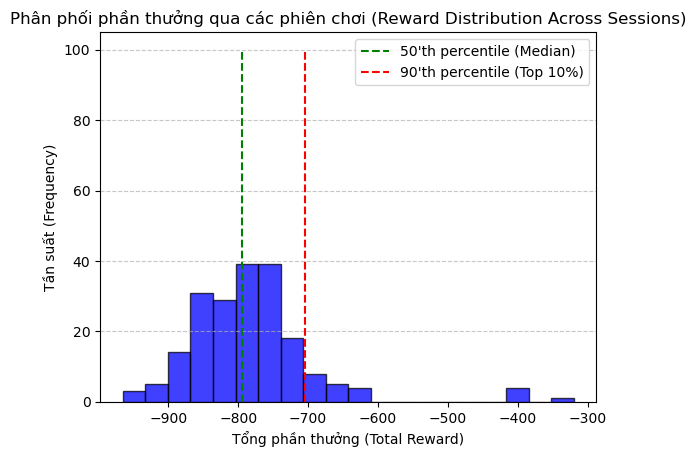

In [35]:
# Xem phân phối phần thưởng ban đầu
import matplotlib.pyplot as plt
%matplotlib inline
## Tạo 200 phiên chơi thử để chạy t_max bằng 1000 bước
sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]
# Vẽ biểu đồ histogram để hiển thị phân phối phần thưởng
plt.hist(sample_rewards, bins=20, alpha=0.75, color='blue', edgecolor='black')
# Vẽ đường thẳng biểu diễn phân vị thứ 50 (Median - trung vị)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile (Median)", color='green', linestyle='dashed')
# Vẽ đường thẳng biểu diễn phân vị thứ 90 (Top 10%)
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile (Top 10%)", color='red', linestyle='dashed')
# Thêm tiêu đề cho biểu đồ
plt.title("Phân phối phần thưởng qua các phiên chơi (Reward Distribution Across Sessions)")
# Nhãn trục x: Tổng điểm
plt.xlabel("Tổng phần thưởng (Total Reward)")
# Nhãn trục y: Tần suất đạt được điểm
plt.ylabel("Tần suất (Frequency)")
# Hiển thị chú thích (legend) cho các đường phân vị
plt.legend()
# Thêm lưới ngang để dễ quan sát
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Hiển thị biểu đồ
plt.show()

### Crossentropy method steps

In [36]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Chọn các trạng thái (states) và hành động (actions) từ các phiên chơi có phần thưởng (reward) >= percentile
    :param states_batch: danh sách các danh sách trạng thái, states_batch[phiên_i][thời_gian_t]
    :param actions_batch: danh sách các danh sách hành động, actions_batch[phiên_i][thời_gian_t]
    :param rewards_batch: danh sách các phần thưởng, rewards_batch[phiên_i]

    :returns: elite_states, elite_actions, đều là các danh sách 1 chiều chứa trạng thái và hành động từ các phiên elite

    Ghi chú: Phải giữ nguyên thứ tự gốc (theo số phiên và thứ tự thời gian trong phiên)
    """

    # Tính ngưỡng phần thưởng (reward threshold) theo percentile yêu cầu
    reward_threshold = np.percentile(rewards_batch, percentile)

    # Khởi tạo danh sách trống để lưu các trạng thái và hành động elite
    elite_states = []
    elite_actions = []

    # Duyệt qua từng phiên chơi, gồm states, actions, và reward tương ứng
    for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
        # Nếu phần thưởng của phiên >= ngưỡng threshold
        if reward >= reward_threshold:
            # Thêm toàn bộ trạng thái của phiên đó vào danh sách elite_states
            elite_states.extend(states)
            # Thêm toàn bộ hành động của phiên đó vào danh sách elite_actions
            elite_actions.extend(actions)

    # Trả về danh sách các trạng thái và hành động elite
    return elite_states, elite_actions


In [37]:
# Dữ liệu đầu vào: Các phiên chơi (games) gồm trạng thái (states), hành động (actions), và phần thưởng (rewards).
states_batch = [
    [1, 2, 3],     # game1: danh sách trạng thái trong game1
    [4, 2, 0, 2],  # game2: danh sách trạng thái trong game2
    [3, 1],        # game3: danh sách trạng thái trong game3
]
actions_batch = [
    [0, 2, 4],     # game1: danh sách hành động trong game1
    [3, 2, 0, 1],  # game2: danh sách hành động trong game2
    [3, 3],        # game3: danh sách hành động trong game3
]
rewards_batch = [
    3,  # game1: phần thưởng của game1
    4,  # game2: phần thưởng của game2
    5,  # game3: phần thưởng của game3
]
# Gọi hàm select_elites với percentile = 0, có nghĩa là chọn tất cả các phiên chơi vì không có phần thưởng tối thiểu
test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)

# Gọi hàm select_elites với percentile = 30, có nghĩa là chỉ chọn các phiên chơi có phần thưởng lớn hơn hoặc bằng phần trăm 30.
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)

# Gọi hàm select_elites với percentile = 90, có nghĩa là chỉ chọn các phiên chơi có phần thưởng lớn hơn hoặc bằng phần trăm 90.
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)

# Gọi hàm select_elites với percentile = 100, có nghĩa là chỉ chọn phiên chơi có phần thưởng lớn nhất.
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

# Kiểm tra kết quả trả về từ hàm select_elites với percentile = 0, phải trả về tất cả trạng thái và hành động theo thứ tự thời gian
assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]), "For percentile 0 you should return all states and actions in chronological order"

# Kiểm tra kết quả trả về từ hàm select_elites với percentile = 30, phải chỉ chọn các phiên có reward trong top 30%
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and np.all(
    test_result_30[1] == [3, 2, 0, 1, 3, 3]), "For percentile 30 you should only select states/actions from two first"

# Kiểm tra kết quả trả về từ hàm select_elites với percentile = 90, phải chỉ chọn phiên có reward trong top 10%
assert np.all(test_result_90[0] == [3, 1]) and np.all(
    test_result_90[1] == [3, 3]), "For percentile 90 you should only select states/actions from one game"

# Kiểm tra kết quả trả về từ hàm select_elites với percentile = 100, phải chọn phiên có phần thưởng cao nhất
assert np.all(test_result_100[0] == [3, 1]) and np.all(
    test_result_100[1] == [3, 3]), "Please make sure you use >=, not >. Also double-check how you compute percentile."

# Nếu không có lỗi, in ra "Ok!" để xác nhận các kết quả đều đúng
print("Ok!")


Ok!


In [38]:
def get_new_policy(elite_states, elite_actions):
    """
    Dựa trên danh sách các trạng thái/hành động elite từ select_elites,
    trả về một chính sách mới, trong đó xác suất của mỗi hành động tỷ lệ thuận với

        policy[s_i, a_i] ~ #[số lần xuất hiện của s_i và a_i trong các trạng thái/hành động elite]
    Đừng quên chuẩn hóa chính sách để có xác suất hợp lệ và xử lý trường hợp 0/0.
    Đối với các trạng thái chưa được thăm, sử dụng phân phối đồng đều (1/n_actions cho tất cả các trạng thái).

    :param elite_states: Danh sách 1D các trạng thái từ các phiên elite
    :param elite_actions: Danh sách 1D các hành động từ các phiên elite
    """
    # Khởi tạo chính sách mới với giá trị ban đầu là 0
    new_policy = np.zeros([n_states, n_actions])  # new_policy là một ma trận có kích thước n_states x n_actions

    ##<YOUR CODE: thiết lập xác suất cho các hành động dựa trên các trạng thái và hành động elite>
    # Đếm số lần xuất hiện của từng cặp (state, action)
    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1  # Tăng giá trị tại (state, action) tương ứng mỗi khi gặp cặp (state, action)

    # Chuẩn hóa xác suất để đảm bảo tổng xác suất của mỗi trạng thái bằng 1
    for state in range(n_states):  # Duyệt qua tất cả các trạng thái
        if np.sum(new_policy[state]) > 0:  # Nếu trạng thái này đã xuất hiện ít nhất một lần
            # Nếu trạng thái đã được ghé thăm, chuẩn hóa xác suất (tổng xác suất của các hành động phải bằng 1)
            new_policy[state] /= np.sum(new_policy[state])  # Chia cho tổng giá trị của tất cả các hành động
        else:
            # Nếu trạng thái chưa được ghé thăm, gán xác suất đồng đều cho tất cả các hành động
            new_policy[state] = 1.0 / n_actions  # Chia đều xác suất giữa tất cả các hành động

    # Đừng quên thiết lập 1/n_actions cho tất cả các hành động trong các trạng thái chưa được thăm.

    return new_policy  # Trả về chính sách mới (một ma trận xác suất)


In [42]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]  # Danh sách các trạng thái trong các phiên chơi elite
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]  # Danh sách các hành động tương ứng với mỗi trạng thái trong các phiên chơi elite

# Gọi hàm get_new_policy để tính toán chính sách mới dựa trên các trạng thái và hành động elite
new_policy = get_new_policy(elite_states, elite_actions)

# Kiểm tra xem chính sách mới có chứa giá trị NaN hoặc vô hạn (inf) không
assert np.isfinite(new_policy).all(), "Chính sách mới của bạn chứa NaN hoặc +-inf. Hãy chắc chắn rằng bạn không chia cho 0."

# Kiểm tra xem tất cả xác suất hành động có phải là giá trị không âm (>=0) không
assert np.all(new_policy >= 0), "Chính sách mới của bạn không thể có xác suất hành động âm."

# Kiểm tra xem tổng xác suất của mỗi trạng thái có bằng 1 không (đảm bảo đây là một phân phối xác suất hợp lệ)
assert np.allclose(new_policy.sum(axis=-1), 1), "Chính sách mới của bạn phải là một phân phối xác suất hợp lệ, tức là tổng xác suất phải bằng 1 cho mỗi trạng thái."

# Định nghĩa câu trả lời tham chiếu (reference_answer) để kiểm tra tính đúng đắn của chính sách mới
reference_answer = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0],  # Trạng thái 0: 100% hành động 0
        [0.5, 0.0, 0.0, 0.5, 0.0],  # Trạng thái 1: 50% hành động 0, 50% hành động 3
        [0.0, 0.33333333, 0.66666667, 0.0, 0.0],  # Trạng thái 2: 33% hành động 1, 67% hành động 2
        [0.0, 0.0, 0.0, 0.5, 0.5],  # Trạng thái 3: 50% hành động 3, 50% hành động 4
    ]
)

# Kiểm tra xem chính sách mới có khớp với câu trả lời tham chiếu (reference_answer) không cho các trạng thái và hành động đầu tiên
assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")  # In ra thông báo "Ok!" nếu tất cả các kiểm tra đều thành công


Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [43]:
from IPython.display import clear_output  # Nhập hàm clear_output từ thư viện IPython để xóa kết quả cũ trong môi trường Jupyter Notebook
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    Hàm tiện ích để hiển thị tiến trình huấn luyện.
    Không có toán học phức tạp ở đây, chỉ là các biểu đồ.
    """
    mean_reward = np.mean(rewards_batch)  # Tính toán phần thưởng trung bình từ batch phần thưởng
    threshold = np.percentile(rewards_batch, percentile)  # Tính toán ngưỡng phần thưởng tại percentile đã cho
    log.append([mean_reward, threshold])  # Thêm giá trị phần thưởng trung bình và ngưỡng vào log
    
    plt.figure(figsize=[8, 4])  # Tạo một biểu đồ mới với kích thước 8x4 inch
    plt.subplot(1, 2, 1)  # Tạo một subplot với 1 hàng và 2 cột, và đặt đồ họa hiện tại ở vị trí đầu tiên
    
    # Vẽ biểu đồ phần thưởng trung bình theo thời gian
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    
    # Vẽ biểu đồ ngưỡng phần thưởng theo thời gian
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()  # Hiển thị chú thích trên đồ thị
    plt.grid()  # Hiển thị lưới trên đồ thị
    plt.subplot(1, 2, 2)  # Tạo một subplot ở vị trí thứ hai (cùng hàng, cột thứ 2)
    
    # Vẽ histogram của batch phần thưởng trong khoảng giá trị reward_range
    plt.hist(rewards_batch, range=reward_range)
    
    # Vẽ một đường thẳng đứng để biểu thị ngưỡng phần thưởng tại percentile (màu đỏ)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],  # Đặt vị trí ngưỡng percentile
        [0],  # Đoạn thẳng bắt đầu từ giá trị 0 trên trục y
        [100],  # Đoạn thẳng kết thúc ở giá trị 100 trên trục y (hoặc giá trị thích hợp)
        label="percentile",  # Thêm nhãn cho đường thẳng
        color="red",  # Đặt màu cho đường thẳng là đỏ
    )
    plt.legend()  # Hiển thị chú thích trên đồ thị
    plt.grid()  # Hiển thị lưới trên đồ thị
    clear_output(True)  # Xóa tất cả các kết quả trước đó trong Jupyter Notebook để chỉ hiển thị đồ thị mới
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))  # In ra phần thưởng trung bình và ngưỡng phần thưởng
    plt.show()  # Hiển thị các đồ thị đã vẽ lên màn hình


In [44]:
# Đặt lại chính sách
policy = initialize_policy(n_states, n_actions)


mean reward = -47.416, threshold=6.500


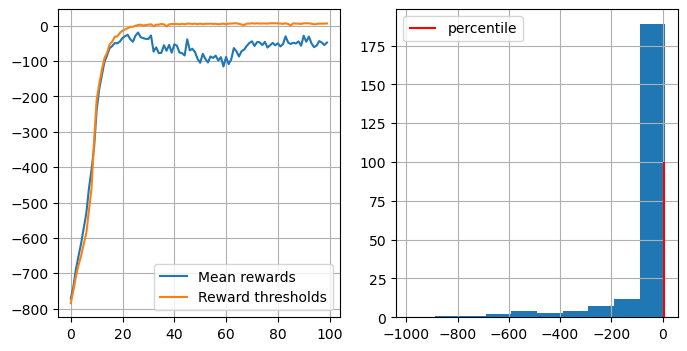

In [45]:
_sessions = 250  # Số lượng phiên chơi được tạo ra
percentile = 50  # Loại bỏ 50% các phiên chơi có điểm thấp nhất
learning_rate = 0.5 # Tốc độ cập nhật chính sách, giá trị từ 0 đến 1

log = []  # Danh sách để lưu trữ thông tin về tiến trình huấn luyện

for i in range(100):  # Lặp qua 100 vòng huấn luyện
    # Tạo danh sách n_sessions phiên chơi mới
    %time sessions = [generate_session(env, policy) for _ in range(_sessions)]

    # Tách danh sách các trạng thái, hành động và phần thưởng từ các phiên chơi
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    # Chọn các trạng thái và hành động từ các phiên chơi tốt nhất (elite)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    # Tính toán chính sách mới dựa trên các trạng thái và hành động elite
    new_policy = get_new_policy(elite_states, elite_actions)

    # Cập nhật chính sách bằng cách kết hợp chính sách cũ và chính sách mới
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # Hiển thị kết quả trên biểu đồ
    show_progress(rewards_batch, log, percentile)

### Reflecting on results

You may have noticed that the taxi problem quickly converges from less than -1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or change the way you evaluate strategy (theoretically correct way). For each starting state, you can sample an action randomly, and then evaluate this action by running _several_ games starting from it and averaging the total reward. Choosing elite sessions with this kind of sampling (where each session's reward is counted as the average of the rewards of all sessions with the same starting state and action) should improve the performance of your policy.


### You're not done yet!

Go to [`./deep_crossentropy_method.ipynb`](./deep_crossentropy_method.ipynb) for a more serious task